<a href="https://colab.research.google.com/github/aaryangrg/DL/blob/master/MNIST%20-%20CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Check for GPU
!nvidia-smi

Sun Jan  8 12:59:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Import torch
import torch

# Exercises require PyTorch > 1.10.0
print(torch.__version__)



1.13.0+cu116


In [4]:
from torch import nn
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

train_data = MNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor(),
)
test_data = MNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor(),
)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



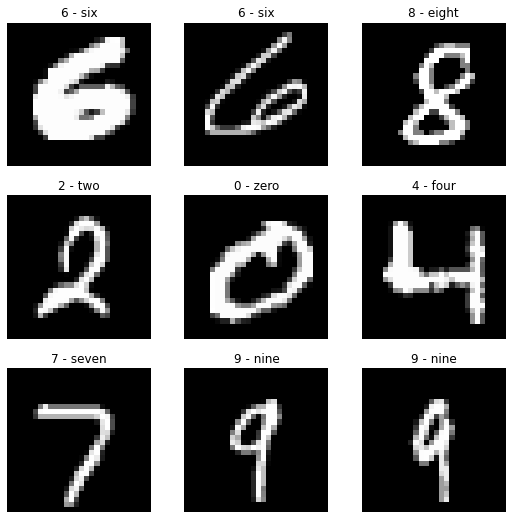

In [5]:
import matplotlib.pyplot as plt
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 3, 3
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(train_data.classes[label])
    plt.axis(False);

In [6]:
from torch.utils.data import DataLoader
batch_size = 32
batched_train_data = DataLoader(train_data, batch_size=batch_size, shuffle=True)
batched_test_data = DataLoader(test_data, batch_size = batch_size, shuffle = True)
batch_train_X, batch_train_y = next(iter(batched_train_data))
batch_test_X, batch_train_y = next(iter(batched_test_data))

In [7]:
class TinyVGGModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.block1 = nn.Sequential(
        # 1 x 28 x 28
        nn.Conv2d(in_channels = 1, out_channels = 10, kernel_size = 3, stride = 1),
        # 10 x 26 x 26
        nn.ReLU()
    )
    self.block2 = nn.Sequential(
        nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size = 3, stride = 1),
        # 10x 24 x 24
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
        # 10 x 12 x 12
    )
    self.block3 = nn.Sequential(
        #10x 12 x 12
        nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size = 3, stride = 1),
        nn.ReLU(),
        # 10x10x10
        nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size = 3, stride = 1),
        #10 x 8 x 8
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
        #10 x 4 x 4
    )
    self.block4 = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = 10*4*4, out_features = 10)
    )

  def forward(self,X):
    out1 = self.block1(X)
    out2 = self.block2(out1)
    out3 = self.block3(out2)
    out4 = self.block4(out3)
    return out4

In [8]:
model = TinyVGGModel()
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

TinyVGGModel(
  (block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block4): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=160, out_features=10, bias=True)
  )
)

In [9]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)

In [10]:
from IPython.lib.display import YouTubeVideo
# Testing on CPU
EPOCHS = 5 
model.to("cpu")
for epoch in range(EPOCHS):
  epoch_train_loss, epoch_test_loss = 0, 0 
  for batch_no, (batch, labels) in enumerate(batched_train_data):
    # batch is [32 , 1, 28, 28] --> contains 32 samples
    model.train()
    y_logits = model(batch)
    y_preds = nn.Softmax(dim = 1)
    y_preds = y_preds(y_logits)
    optimizer.zero_grad()
    loss = loss_fn(y_logits, labels)
    epoch_train_loss += loss
    loss.backward()
    optimizer.step()

    if batch_no % 500 == 0:
      print("EPOCH : ", epoch , "BATCH : ", batch_no , "BATCH LOSS : ",loss)
  print("EPOCH : ", epoch , "EPOCH LOSS : ",epoch_train_loss)






EPOCH :  0 BATCH :  0 BATCH LOSS :  tensor(2.2893, grad_fn=<NllLossBackward0>)
EPOCH :  0 BATCH :  500 BATCH LOSS :  tensor(0.2387, grad_fn=<NllLossBackward0>)
EPOCH :  0 BATCH :  1000 BATCH LOSS :  tensor(0.1622, grad_fn=<NllLossBackward0>)
EPOCH :  0 BATCH :  1500 BATCH LOSS :  tensor(0.0646, grad_fn=<NllLossBackward0>)
EPOCH :  0 EPOCH LOSS :  tensor(565.1100, grad_fn=<AddBackward0>)
EPOCH :  1 BATCH :  0 BATCH LOSS :  tensor(0.0505, grad_fn=<NllLossBackward0>)
EPOCH :  1 BATCH :  500 BATCH LOSS :  tensor(0.0523, grad_fn=<NllLossBackward0>)
EPOCH :  1 BATCH :  1000 BATCH LOSS :  tensor(0.1307, grad_fn=<NllLossBackward0>)
EPOCH :  1 BATCH :  1500 BATCH LOSS :  tensor(0.0196, grad_fn=<NllLossBackward0>)
EPOCH :  1 EPOCH LOSS :  tensor(155.0345, grad_fn=<AddBackward0>)
EPOCH :  2 BATCH :  0 BATCH LOSS :  tensor(0.0752, grad_fn=<NllLossBackward0>)
EPOCH :  2 BATCH :  500 BATCH LOSS :  tensor(0.0185, grad_fn=<NllLossBackward0>)
EPOCH :  2 BATCH :  1000 BATCH LOSS :  tensor(0.1572, grad_f

In [11]:
model.eval()
import random
indices = [random.randint(1,10000) for i in range(5)]
for index in indices :
  data, label = test_data[index]
  logits = model(data.unsqueeze(dim=0))
  pred = torch.nn.Softmax(dim = 1)
  pred = pred(logits)
  print(pred.argmax(dim=1),label)

tensor([7]) 7
tensor([8]) 8
tensor([2]) 2
tensor([5]) 5
tensor([5]) 5


In [27]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 36.6 MB/s eta 0:00:00


## 11. Plot a confusion matrix comparing your model's predictions to the truth labels.

In [32]:
from sklearn.metrics import confusion_matrix
from torchmetrics import Accuracy
import seaborn as sb
import pandas as pd

y_pred = []
y_true = []

for inputs, labels in batched_test_data : 
  model.eval()
  ys = model(inputs)
  pred = torch.nn.Softmax(dim = 1)
  pred = pred(ys).argmax(dim=1)
  y_pred.extend(pred.detach().numpy())
  y_true.extend(labels.detach().numpy())


accuracy_fn = Accuracy(task = "multiclass", num_classes = len(test_data.classes))
accuracy = accuracy_fn(torch.Tensor(y_true), torch.Tensor(y_pred))
cmat = confusion_matrix(y_true, y_pred)
print("Model Accuracy : ", accuracy)
print("Confusion Matrix : \n", cmat)


Model Accuracy :  tensor(0.9828)
Confusion Matrix : 
 [[ 973    0    0    0    1    2    2    1    1    0]
 [   0 1116    2    3    1    1    2    2    8    0]
 [   1    0 1004    6    3    3    0   12    3    0]
 [   0    0    2  997    0    9    0    1    1    0]
 [   0    0    0    1  973    0    0    0    0    8]
 [   0    0    0    7    0  884    0    0    1    0]
 [   5    3    0    0    5   12  932    0    1    0]
 [   0    2    2    4    0    0    0 1015    2    3]
 [   3    0    1    2    1   10    0    3  948    6]
 [   1    0    0    0    5   12    0    3    2  986]]


In [39]:
tensor = torch.rand(size = (1,3,64,64))
layer = nn.Conv2d(in_channels = 3, out_channels = 10, kernel_size = 2, stride = 1)
layer(tensor)

tensor([[[[ 4.4976e-01,  4.5803e-01,  5.5250e-01,  ...,  2.6815e-01,
            2.6042e-01,  2.0007e-01],
          [ 6.2417e-01,  6.6527e-01,  2.4755e-01,  ...,  5.3267e-01,
            3.1073e-01,  4.8711e-01],
          [ 4.4049e-01,  6.8568e-01,  7.5224e-01,  ...,  5.3483e-01,
            3.4409e-01,  3.3975e-01],
          ...,
          [ 2.1061e-01,  3.4616e-01,  3.3808e-01,  ...,  3.6285e-01,
            6.9336e-01,  4.6209e-01],
          [ 7.6353e-01,  5.8830e-01,  3.3142e-01,  ...,  8.4561e-01,
            7.3662e-01,  5.8063e-01],
          [ 5.0253e-01,  2.0470e-01,  4.8313e-01,  ...,  6.3010e-01,
            2.5290e-01,  6.3257e-01]],

         [[ 3.7289e-01,  6.1189e-01,  3.7646e-01,  ...,  3.2166e-01,
            6.0559e-01,  4.1739e-01],
          [ 4.2156e-01,  4.8658e-01,  3.1829e-01,  ...,  4.5495e-01,
            5.1966e-01,  2.2904e-01],
          [ 6.6728e-01,  4.9862e-01,  4.0209e-01,  ...,  2.8733e-01,
            3.7977e-01,  1.7065e-01],
          ...,
     

In [41]:
from pathlib import Path


FILE_NAME = "TinyVGGmodel.pth"


print(model.state_dict())
torch.save(model.state_dict(), FILE_NAME)

OrderedDict([('block1.0.weight', tensor([[[[ 0.0507, -0.1557,  0.0849],
          [-0.1535, -0.0391, -0.1353],
          [ 0.2238, -0.2630, -0.1537]]],


        [[[-0.0941, -0.1978,  0.0383],
          [-0.3278,  0.3061, -0.2806],
          [ 0.2564,  0.0531, -0.1116]]],


        [[[ 0.0437,  0.0892,  0.2224],
          [ 0.0134,  0.2189,  0.3931],
          [-0.1426,  0.0844,  0.2122]]],


        [[[ 0.4482,  0.1134,  0.4401],
          [ 0.0721,  0.0320, -0.3234],
          [-0.6058, -0.5321, -0.6421]]],


        [[[ 0.2424,  0.3894,  0.3366],
          [ 0.2175,  0.2728,  0.2662],
          [-0.1686, -0.2141, -0.5000]]],


        [[[ 0.0678,  0.0579,  0.2606],
          [-0.1182,  0.4041, -0.0608],
          [-0.2829, -0.3232,  0.3706]]],


        [[[ 0.0800,  0.2883, -0.3001],
          [-0.3468, -0.2801, -0.2347],
          [ 0.1698,  0.1560,  0.2970]]],


        [[[-0.1717, -0.2238,  0.1913],
          [-0.1264,  0.2180, -0.0677],
          [ 0.2067, -0.2568, -0.1676]]],

